In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0


In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input
import matplotlib.pyplot as plt
import numpy as np
import cv2

### Создание и обучение нейрнной сети

Загружаем датасет

In [27]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [28]:
x_dataset = tf.data.Dataset.from_tensor_slices(x_train)
y_dataset = tf.data.Dataset.from_tensor_slices(y_train)

def process_x(x):
    img = tf.cast(x, tf.float32) / 255
    return img

def process_y(y):
    y = tf.one_hot(y, 10)
    return y

x_dataset = x_dataset.map(process_x)
y_dataset = y_dataset.map(process_y)
dataset = tf.data.Dataset.zip((x_dataset, y_dataset))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(64)
AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

Вывод примера датасета

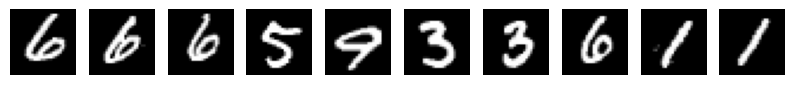

In [29]:
def imshow():    
    n = 10
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(n):
            img = images[i]
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(img, cmap='gist_gray')
            plt.axis('off')
            ax.get_yaxis().set_visible(False)
    plt.show()
imshow()

Создаем неронную сеть

In [30]:
inputs = Input(shape=(28, 28))
x = Flatten()(inputs)
x = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(10, activation = 'sigmoid')(x)
outputs = x
simple_nn = keras.Model(inputs, outputs)

In [31]:
class Model(tf.keras.Model):
    def __init__(self, nn):
        super(Model, self).__init__()
        self.nn = nn
        
    def get_loss(self, y, preds):
        loss = tf.keras.losses.CategoricalCrossentropy()(y, preds)
        return loss
        
    @tf.function
    def training_step(self, x , y):
        with tf.GradientTape() as tape:
            preds = self.nn(x)
            loss = self.get_loss(y, preds)
            
        gradients = tape.gradient(loss, self.nn.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.nn.trainable_variables))
        return tf.reduce_mean(loss)   

In [32]:
model = Model(simple_nn)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

Обучаем нейронную сеть

20


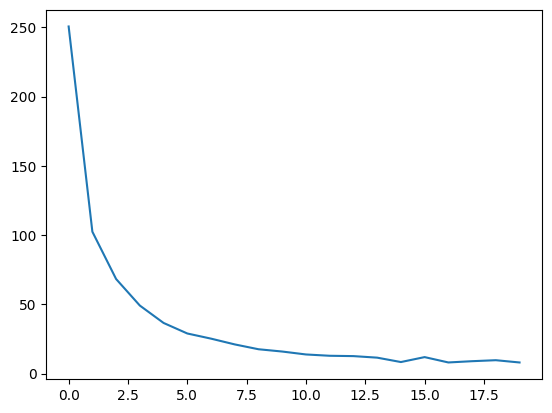

In [33]:
from IPython.display import clear_output
hist = np.array(np.empty([0]))
epochs = 20
for epoch in range(1, epochs + 1):
    loss = 0
    for step, (x, y) in enumerate(dataset):
        loss+=model.training_step(x, y)
    clear_output(wait=True)
    print(epoch)
    hist = np.append(hist, loss)
    plt.plot(np.arange(0,len(hist)), hist)
    plt.show()

Смотрим результат обучения сети

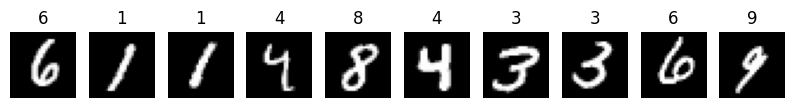

In [34]:
def imshow_and_pred():    
    n = 10
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        for i in range(n):
            img = images[i]
            img_tensor = tf.expand_dims(img, axis = 0)
            pred = model.nn(img_tensor)
            pred = tf.squeeze(pred, axis =0)
            pred = pred.numpy()
            
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(img, cmap='gist_gray')
            
            ma = pred.max()
            res = np.where(pred == ma)
            
            plt.title(res[0][0])
            plt.axis('off')
            ax.get_yaxis().set_visible(False)           
    plt.show()
imshow_and_pred()

Тестируем нейронную сеть на пользовательских картинках

In [35]:
my_img = cv2.imread('test.png')
my_img = my_img
img_tensor = tf.expand_dims(my_img, axis = 0)
img_tensor = tf.cast(img_tensor, tf.float32) / 255
img_tensor = tf.image.resize(img_tensor, (28, 28), method='area')
img_numpy= img_tensor.numpy()
img_numpy = img_numpy[:,:,:,0]

pred = model.nn(img_numpy)
pred = tf.squeeze(pred, axis =0)
pred = pred.numpy()

ma = pred.max()
res = np.where(pred == ma)
print(res[0][0])

5


Сохранение обученой нейронной сети

In [36]:
model.nn.save("my_model.h5")

### Загрузка обученой нейронной сети

In [40]:
inputs = Input(shape=(28, 28))
x = Flatten()(inputs)
x = Dense(128, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(10, activation = 'sigmoid')(x)
outputs = x
simple_nn = keras.Model(inputs, outputs)

In [41]:
class Model(tf.keras.Model):
    def __init__(self, nn):
        super(Model, self).__init__()
        self.nn = nn
        
    def get_loss(self, y, preds):
        loss = tf.keras.losses.CategoricalCrossentropy()(y, preds)
        return loss
        
    @tf.function
    def training_step(self, x , y):
        with tf.GradientTape() as tape:
            preds = self.nn(x)
            loss = self.get_loss(y, preds)
            
        gradients = tape.gradient(loss, self.nn.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.nn.trainable_variables))
        return tf.reduce_mean(loss)   

In [49]:
model = Model(simple_nn)

In [50]:
import os
model.nn.load_weights(os.path.join('my_model.h5'))

In [51]:
my_img = cv2.imread('test.png')
my_img = my_img
img_tensor = tf.expand_dims(my_img, axis = 0)
img_tensor = tf.cast(img_tensor, tf.float32) / 255
img_tensor = tf.image.resize(img_tensor, (28, 28), method='area')
img_numpy= img_tensor.numpy()
img_numpy = img_numpy[:,:,:,0]

pred = model.nn(img_numpy)
pred = tf.squeeze(pred, axis =0)
pred = pred.numpy()

ma = pred.max()
res = np.where(pred == ma)
print(res[0][0])

5
